In [86]:
import requests
from fake_useragent import UserAgent
from bs4 import BeautifulSoup
from datetime import datetime
from re import search
import json
from time import sleep
from random import uniform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

# Парсинг ссылок
Вдохновившись новостями по нобелевской неделе, для парсинга я выбрал сайт Naked Science, который содержит научнопопулярные статьи и новости из мира науки. Из раздела со всеми новостями будем парсить по страницам название каждой статьи, автора, аннотацию, индекс важности (оценка автором важности исследования/открытия для науки), дату публикации, хэштеги, количество просмотров в качестве целевой переменной, и наконец ссылки.

In [2]:
# Так как дата публикации и число просмотров имеет разные форматы, сделаем функцию для их извлечения

def parse_date(date, form='%d.%m.%Y'):
    mapper = {
        'января': '01',
        'февраля': '02',
        'марта': '03',
        'апреля': '04',
        'мая': '05',
        'июня': '06',
        'июля': '07',
        'августа': '08',
        'сентября': '09',
        'октября': '10',
        'ноября': '11',
        'декабря': '12'
    }
    if search(r'\d{1,2}\.\d{2}\.\d{4}', date):
        return date
    else:
        date = date.split()
        day = '0' + date[0] if len(date[0]) < 2 else date[0]
        return '.'.join((day, mapper[date[1]], '2025'))

def parse_views(v):
    if v[-3:] == 'тыс':
        num = v.split()[0]
        num = num.replace(',', '.')
        v = float(num) * (10 ** 3)
    
    return int(v)

In [3]:
def get_info(obj):
    header = obj.find('a', attrs={'class': 'animate-custom'})
    link = header.attrs['href'].strip()
    
    title = header.get_text().split()
    imp_ind = float(title[-1])
    title = ' '.join(title[:-1])

    author = obj.find(lambda tag: tag.name == 'div' and tag.get('class') == ['meta-item', 'meta-item_author'])
    author = author.string.strip()

    date = obj.find('span', attrs={'class': 'echo_date'}).string
    date = parse_date(date.split(', ')[0])

    views = obj.find('span', attrs={'class': 'fvc-count'}).string
    views = parse_views(views)

    annot = obj.find('p').string.strip()

    tags = obj.find(lambda tag: tag.name == 'div' and tag.get('class') == ['terms-items', 'grid'])
    tags = tags.find_all('div', attrs={'class': 'terms-item'})
    tags = [t.get_text().replace('#', '').strip() for t in tags]

    return {
        'title': title,
        'author': author,
        'date': date,
        'imp_ind': imp_ind,
        'views': views,
        'annot': annot,
        'tags': tags,
        'link': link
    }

In [7]:
user_ag = UserAgent()
main_link = 'https://naked-science.ru/article/page/'
attemps = 0
success = []

start, pages = 10, 500
articles, links = [], []

for i in range(start, pages + start): # начнем пасрить с 10 страницы, чтобы количество просмотров и коммментов уже немного установилось
    if i % 5 == 0 and i != start:
        print(f'processing page {i - start}/{pages}')
        with open('articles_links.json', 'w', encoding='UTF-8') as f:
            json.dump(articles, f, ensure_ascii=False, indent=4)
    
    for j in range(3): # Пытаемся спарсить страницу три раза, если не удалось, увеличиваем счеткчик неудачных попыток
        sleep(uniform(1.1, 1.9))
        response = requests.get(main_link + f'{i}/', headers={'User-Agent': user_ag.random})
        if not response.ok:
            print(f'\n  WARNING: page {i - start} parsing failed\n')
            continue
        else:
            success.append(i)
            attemps = 0
            soup = BeautifulSoup(response.content, 'html.parser')
            news = soup.find('div', attrs={'class': 'news-items'})
            news = news.find_all(lambda tag: tag.name == 'div' and tag.get('class') == ['news-item-left', 'with-bookmark'])
            for x in news:
                try:
                    a = get_info(x)
                    if a['link'] not in links: # Некоторые статьи могут парситься дважды, поэтому проверяем
                        articles.append(a)
                        links.append(a['link'])
                except:
                    pass
            break
    else:
        attemps += 1

    if attemps > 3:
        # Если не удалось спарсить больше трех страниц подряд, будем прерывать процесс
        print(f'\n  WARNING: Parsing was stopped\n')
        break


print(f'\n --- {len(success)}/{pages} pages have been successfully parsed ---')

processing page 5/500
processing page 10/500
processing page 15/500
processing page 20/500
processing page 25/500
processing page 30/500
processing page 35/500
processing page 40/500
processing page 45/500
processing page 50/500
processing page 55/500
processing page 60/500
processing page 65/500
processing page 70/500
processing page 75/500
processing page 80/500
processing page 85/500
processing page 90/500
processing page 95/500
processing page 100/500
processing page 105/500
processing page 110/500
processing page 115/500
processing page 120/500
processing page 125/500
processing page 130/500
processing page 135/500
processing page 140/500
processing page 145/500
processing page 150/500
processing page 155/500
processing page 160/500
processing page 165/500
processing page 170/500
processing page 175/500
processing page 180/500
processing page 185/500
processing page 190/500
processing page 195/500
processing page 200/500
processing page 205/500
processing page 210/500
processing p

# Парсинг статей

In [10]:
with open('articles_links.json', 'r', encoding='UTF-8') as f:
    articles = json.load(f)
len(articles)

8272

In [11]:
def parse_page(responce, par_sep='\n'):
    soup = BeautifulSoup(response.content, 'html.parser')
    obj = soup.find('div', attrs={'class': 'body'}).find_all('p')
    text = par_sep.join([par.get_text().strip() for par in obj])

    comments = soup.find('div', attrs={'class': 'shesht-comments-list'})
    comments = comments.find_all('div', attrs={'class': 'shesht-comment-template__content-text'})
    comments = [co.get_text().strip() for co in comments]

    return {'text': text, 'comments': comments}

In [15]:
user_ag = UserAgent()
attemps = 0
success = []

all_pages = len(articles)
pages, links = [], [x['link'] for x in articles]

for i, link in enumerate(links):
    if i % 5 == 0 and i != 0:
        print(f'processing page {i}/{all_pages}')
        with open('texts_comments.json', 'w', encoding='UTF-8') as f:
            json.dump(pages, f, ensure_ascii=False, indent=4)
    
    for j in range(3): # Пытаемся спарсить страницу три раза, если не удалось, увеличиваем счеткчик неудачных попыток
        sleep(uniform(1.1, 1.9))
        response = requests.get(link, headers={'User-Agent': user_ag.random})
        if not response.ok:
            print(f'\n  WARNING: page {i} parsing failed\n')
            continue
        else:
            success.append(i)
            attemps = 0
            try:
                a = parse_page(response)
                a['link'] = link
                pages.append(a)
            except:
                pass
            break
    else:
        attemps += 1

    if attemps > 3:
        # Если не удалось спарсить больше трех страниц подряд, будем прерывать процесс
        print(f'\n  WARNING: Parsing was stopped\n')
        break


print(f'\n --- {len(success)}/{all_pages} pages have been successfully parsed ---')
with open('texts_comments.json', 'w', encoding='UTF-8') as f:
            json.dump(pages, f, ensure_ascii=False, indent=4)

processing page 5/8272
processing page 10/8272
processing page 15/8272
processing page 20/8272
processing page 25/8272
processing page 30/8272
processing page 35/8272
processing page 40/8272
processing page 45/8272
processing page 50/8272
processing page 55/8272
processing page 60/8272
processing page 65/8272
processing page 70/8272
processing page 75/8272
processing page 80/8272
processing page 85/8272
processing page 90/8272
processing page 95/8272
processing page 100/8272
processing page 105/8272
processing page 110/8272
processing page 115/8272
processing page 120/8272
processing page 125/8272
processing page 130/8272
processing page 135/8272
processing page 140/8272
processing page 145/8272
processing page 150/8272
processing page 155/8272
processing page 160/8272
processing page 165/8272
processing page 170/8272
processing page 175/8272
processing page 180/8272
processing page 185/8272
processing page 190/8272
processing page 195/8272
processing page 200/8272
processing page 205/

In [16]:
with open('texts_comments.json', 'r', encoding='UTF-8') as f:
    pages = json.load(f)
len(pages)

8272

# EDA

In [2]:
with open('articles_links.json', 'r', encoding='UTF-8') as f:
    articles = json.load(f)

with open('texts_comments.json', 'r', encoding='UTF-8') as f:
    pages = json.load(f)

original_df = pd.merge(pd.DataFrame(articles), pd.DataFrame(pages), on='link')

In [3]:
original_df

,title,author,date,imp_ind,views,annot,tags,link,text,comments
0,"Ученые обнаружили еще одну причину, по которой...",Игорь Байдов,10.10.2025,5.2,21600,Голые землекопы живут почти 40 лет — невероятн...,"[Биология, голые землекопы, ДНК, долголетие]",https://naked-science.ru/article/biology/uchen...,Обитатели подземных колоний Восточной Африки —...,[Китайские учёные нашли способ как человеку пр...
1,"Бактерии создали из себя батарейку, чтобы разр...",Evgenia Vavilova,10.10.2025,4.2,7800,Они использовали содержащееся в почве железо. ...,"[Биология, аккумулятор, бактерии, биопленки]",https://naked-science.ru/article/biology/bacte...,"Солнечный свет используют не только растения, ...",[]
2,Бактерии и добавки пероксида кальция сделают д...,Губкинский университет,10.10.2025,4.8,149,Ученые РГУ нефти и газа (НИУ) имени И.М. Губки...,"[Губкинский университет, арктика, бактерии, ка...",https://naked-science.ru/article/column/bakter...,"«Ключевые особенности метода в том, что он поз...",[]
3,Российские физики предложили искать темную мат...,ФизТех,10.10.2025,5.1,1000,Большой коллектив российских ученых из ведущих...,"[ФизТех, вселенная, квантование гравитации, те...",https://naked-science.ru/article/column/temnuy...,Описание проекта опубликовано в журнале Physic...,[more CASH for scientists! \r\nХотя стремление...
4,Белорусские ученые вырастили кожу из грибов и ...,Unitsky String Technologies Inc.,10.10.2025,4.5,430,Специалисты UST Inc. разработали технологию по...,"[Unitsky String Technologies Inc., биоматериал...",https://naked-science.ru/article/column/beloru...,В производстве грибной кожи белорусские специа...,[Создание регенерирующего заменителя кожи из г...
...,...,...,...,...,...,...,...,...,...,...
8267,В Испании нашли свой Стоунхендж,Алиса Гаджиева,22.08.2022,4.3,1300,"На поле, предназначенном для выращивания авока...","[Антропология, археология, древние люди, Испания]",https://naked-science.ru/article/anthropology/...,"В провинции Уэльва, расположенной на юго-запад...",[]
8268,Астрономы оценили максимально возможное число ...,Сергей Васильев,22.08.2022,5.2,8600,"Ученые подсчитали, что без больших изменений о...","[Астрономия, естественный спутник, Луна, спутн...",https://naked-science.ru/article/astronomy/mak...,Планеты-гиганты Солнечной системы окружают цел...,[]
8269,Рецепт сознания: могут ли люди и роботы мечтат...,Денис Тулинов,22.08.2022,5.0,7600,В XXI веке вопрос о природе сознания станет од...,"[Технологии, искусственный интеллект, машинное...",https://naked-science.ru/article/hi-tech/retse...,Два громких события — решение Верховного суда ...,"[Отличный материал, отдельное спасибо за ссылк..."
8270,У берегов Западной Африки нашли древний ударны...,Мария Азарова,21.08.2022,6.5,4700,"Ученые допускают, что 66 миллионов лет назад с...","[Геология, астероид, гибель динозавров, диноза...",https://naked-science.ru/article/geology/udarn...,На юго-западе Гвинейской террасы (западная обл...,[Модель импакта совершенно нереалистична. Любы...


In [4]:
original_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8272 entries, 0 to 8271
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   title     8272 non-null   object 
 1   author    8272 non-null   object 
 2   date      8272 non-null   object 
 3   imp_ind   8272 non-null   float64
 4   views     8272 non-null   int64  
 5   annot     8272 non-null   object 
 6   tags      8272 non-null   object 
 7   link      8272 non-null   object 
 8   text      8272 non-null   object 
 9   comments  8272 non-null   object 
dtypes: float64(1), int64(1), object(8)
memory usage: 646.4+ KB


In [64]:
y = original_df['views']
x1 = original_df['imp_ind']
x2 = original_df['text'].map(lambda x: len(x))

y_lim, x2_lim = y.quantile(0.95), x2.quantile(0.99)

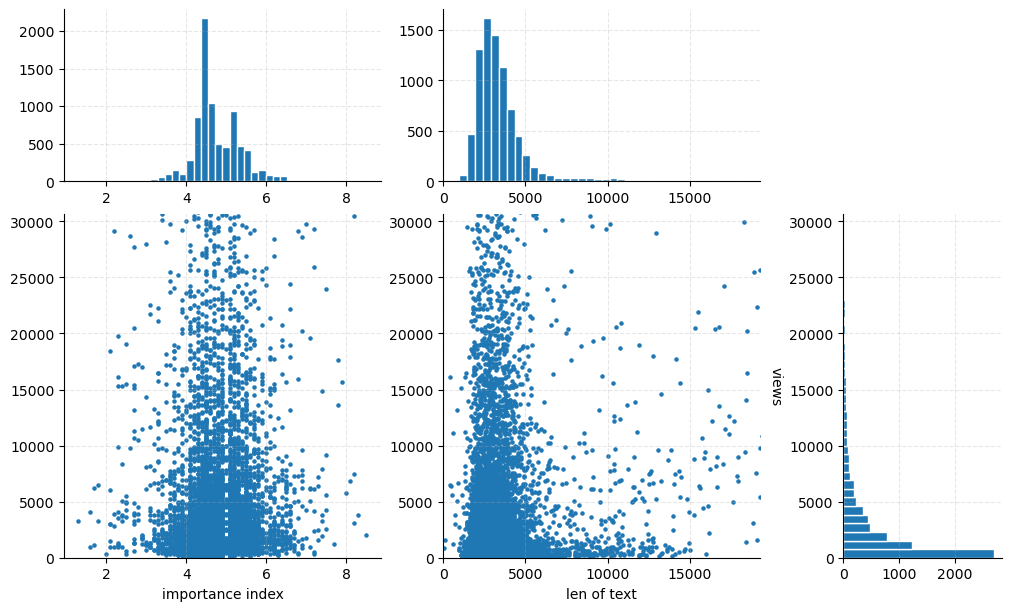

In [102]:
fig, axs = plt.subplot_mosaic([['hist_x1', 'hist_x2', '.'],
                               ['scatter_1', 'scatter_2', 'hist_y']],
                              figsize=(10, 6),
                              width_ratios=(2, 2, 1),
                              height_ratios=(1, 2),
                              layout='constrained')

axs['hist_x1'].hist(x1, bins=40, edgecolor='white')
axs['hist_x2'].hist(x2, bins=40, range=(0, x2_lim), edgecolor='white')
axs['hist_y'].hist(y, bins=40, range=(0, y_lim), orientation='horizontal', edgecolor='white')
axs['scatter_1'].scatter(x1, y, s=5)
axs['scatter_2'].scatter(x2, y, s=5)

axs['scatter_1'].sharey(axs['scatter_2'])
axs['scatter_2'].sharey(axs['hist_y'])
axs['scatter_1'].sharex(axs['hist_x1'])
axs['scatter_2'].sharex(axs['hist_x2'])

axs['scatter_1'].set_ylim(0, y_lim)
axs['scatter_2'].set_ylim(0, y_lim)
axs['scatter_2'].set_xlim(0, x2_lim)

axs['scatter_1'].set_xlabel('importance index')
axs['scatter_2'].set_xlabel('len of text')
axs['hist_y'].set_ylabel('views', rotation=270, labelpad=15)

for ax in axs.values():
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.show()

Видно, что нет явной зависимости числа просмотров от размера статьи и индекса важности